# CNN Cancer Detection Kaggle Mini-Project

## Introduction 

Detecting metastatic cancer in digital pathology images is an important task in medical diagnosi. The dataset used here is a modified version of the PatchCamelyon (PCam) dataset, which has been adjusted to remove duplicate images found in the original version.

For this week's mini-project, I'll go through a Kaggle competition: Histopathologic Cancer Detection. This competition is a binary image classification problem where I'll identify metastatic cancer in small image patches taken from larger digital pathology scans.

The github repo for this work is available at https://github.com/ammarhameed/Cancer-Detection-Kaggle-Mini-Project

In [21]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn
import random
import os
from PIL import Image
from PIL import ImageDraw
train_on_gpu = True
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization, Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.models import Model, load_model
import tensorflow as tf
import pathlib
import seaborn as sns
import tensorflow_io as tfio
from skimage import io 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Add

## Helper functions

In [14]:
def process_image(image_path, center_crop=False):
    image = Image.open(image_path)
    if center_crop:
        width, height = image.size
        left = (width - 32) / 2
        top = (height - 32) / 2
        right = (width + 32) / 2
        bottom = (height + 32) / 2
        image = image.crop((left, top, right, bottom))
    image_array = np.array(image)
    return image_array

def display_images(images, titles, cols=5):
    rows = len(images) // cols + (len(images) % cols > 0)
    plt.figure(figsize=(15, rows * 3))
    
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)  
        plt.title(title)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
def load_images_and_labels(df_labels, 
                           size=10000, 
                           image_width=96, image_height=96, image_channels=3, 
                           image_dir="histopathologic-cancer-detection/train/"):

    df_labels_0 = df_labels[df_labels['label'] == 0].sample(frac=1).reset_index(drop=True)
    df_labels_1 = df_labels[df_labels['label'] == 1].sample(frac=1).reset_index(drop=True)

    samples_per_label = size // 2

    x_train = np.zeros((size, image_width, image_height, image_channels), dtype=np.uint8)
    y_train = np.zeros((size,), dtype=np.uint8)

    
    for i, row in df_labels_0.iterrows():
        if i >= samples_per_label:
            break
        x_train[i] = process_image(os.path.join(image_dir, row['id'] + ".tif"), True)
        y_train[i] = row['label']

    for i, row in df_labels_1.iterrows():
        if i >= samples_per_label:
            break
        x_train[i + samples_per_label] = process_image(os.path.join(image_dir, row['id'] + ".tif"), True)
        y_train[i + samples_per_label] = row['label']

    indices = np.arange(size)
    x_train = x_train[indices]
    y_train = y_train[indices]
    
    return x_train, y_train

import os

def get_image_data(directory):
    image_data = []
    for filename in os.listdir(directory):
        id = filename.split(".")[0]
        path = os.path.join(directory, filename)
        image_data.append({"id": id, "path": path})
    return image_data

def predict_and_save(image_data, model, output_file, image_height=32, image_width=32):
    results_df = pd.DataFrame(columns=['id', 'label'])
    test_set = np.zeros((len(image_data), image_height, image_width, 3))

    for i, image in enumerate(image_data):
        test_set[i] = process_image(image['path'], center_crop=True)
         
    predictions = model.predict(test_set, batch_size=64, verbose='auto')
    predictions = (predictions >= 0.5).astype(int)

    for i, image in enumerate(image_data):
        new_row = pd.DataFrame({'id': image['id'], 'label': predictions[i]}, index=[i])  
        results_df = pd.concat([results_df, new_row], ignore_index=True)           
    results_df.to_csv(output_file, index=False)
        
    return results_df

## EDA

In [ ]:
train_labels_path = "histopathologic-cancer-detection/train_labels.csv"

df_labels = pd.read_csv(train_labels_path)
image_width = 32
image_height = 32
x_train, y_train = load_images_and_labels(df_labels=df_labels, size=100000, image_width=32, image_height=32)
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2)


In [18]:
print(df_labels.head())
print(df_labels.info())
print(df_labels.describe())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
               label
count  220025.000000
mean        0.405031
std         0.490899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


In [19]:
label_counts = df_labels['label'].value_counts()
print(label_counts)

label
0    130908
1     89117
Name: count, dtype: int64


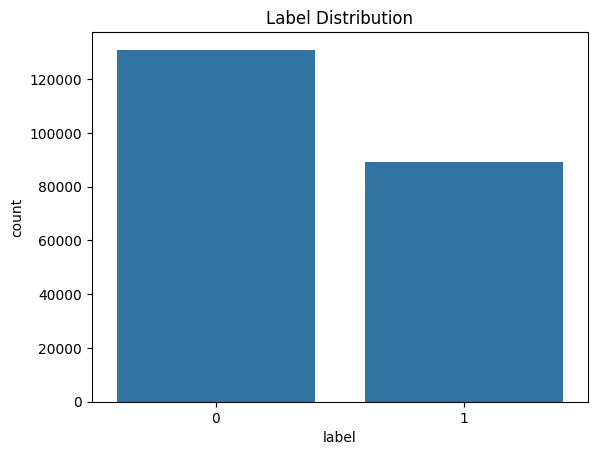

In [22]:
sns.countplot(x='label', data=df_labels)
plt.title('Label Distribution')
plt.show()

In [24]:
print(x_train.shape)  # Check dimensions of images

(80000, 32, 32, 3)


Next I will visualize the training and validation distributions

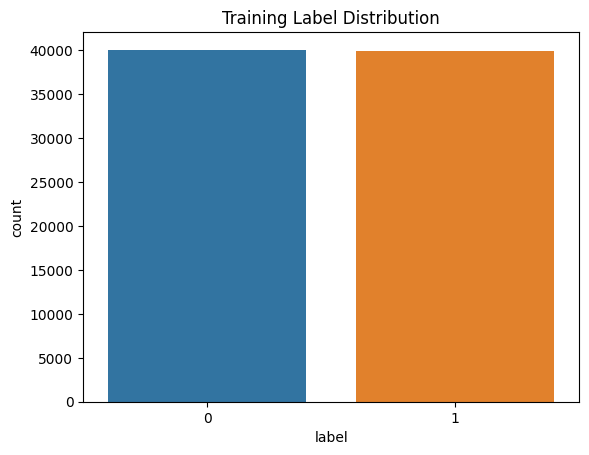

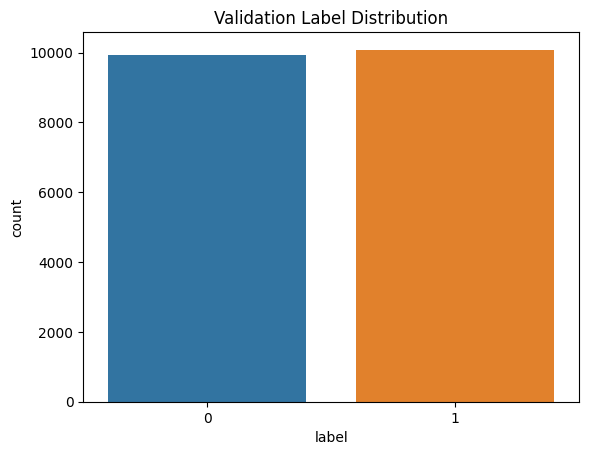

In [27]:
sns.countplot(x='label', hue='label', data=pd.DataFrame(y_train, columns=['label']), legend=False)
plt.title('Training Label Distribution')
plt.show()

sns.countplot(x='label', hue='label', data=pd.DataFrame(y_valid, columns=['label']), legend=False)
plt.title('Validation Label Distribution')
plt.show()

And finally let's view some images

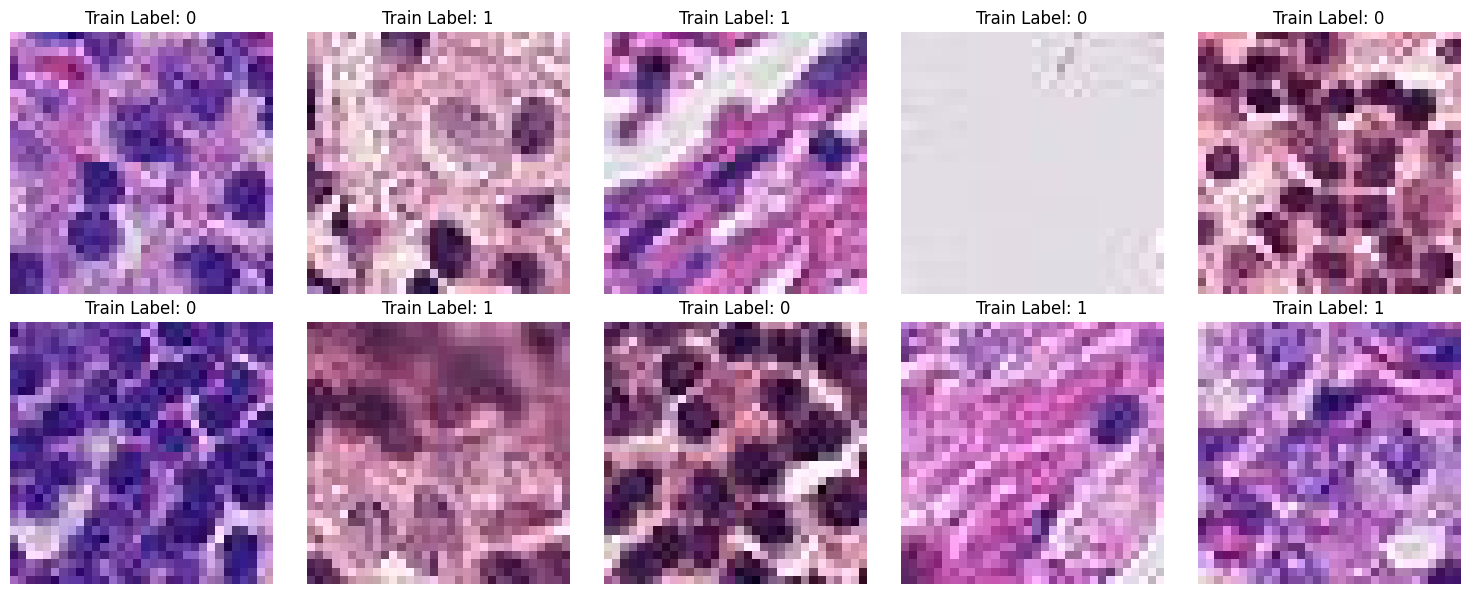

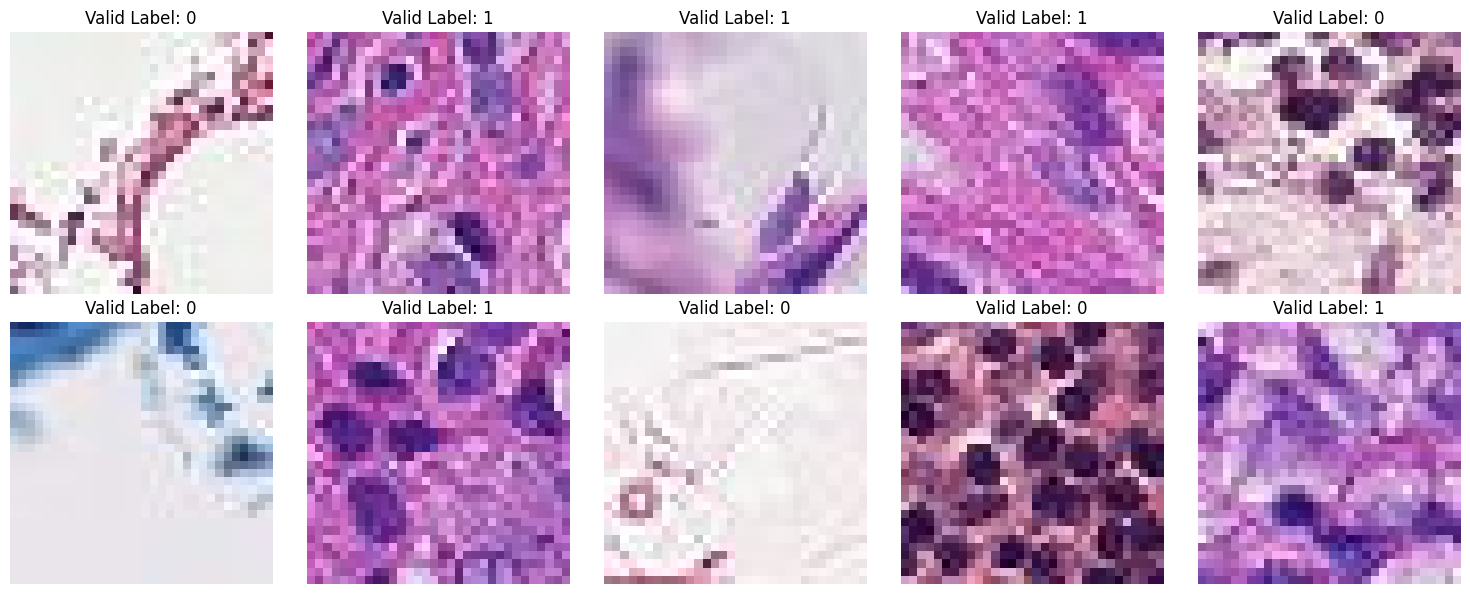

In [28]:

train_sample_indices = np.random.choice(len(x_train), 10, replace=False)
train_sample_images = x_train[train_sample_indices]
train_sample_titles = [f'Train Label: {y_train[idx]}' for idx in train_sample_indices]

valid_sample_indices = np.random.choice(len(x_valid), 10, replace=False)
valid_sample_images = x_valid[valid_sample_indices]
valid_sample_titles = [f'Valid Label: {y_valid[idx]}' for idx in valid_sample_indices]

display_images(train_sample_images, train_sample_titles, cols=5)
display_images(valid_sample_images, valid_sample_titles, cols=5)


## CNN Model

Next I started building the model, I built a convolutional neural network (CNN) model using Keras with the following Aarchitecture

**Model Architecture**

- Sequential Model . 
  
- Block 1: This block contains the following:  
    - 2 Convolutional layers
    - Batch Normalization layer
    - BatchNormalization()
    - Max Pooling:
    - And finally a Dopout layer


- Block 2: Similar to Block 1 but with 128 filters.
  
- Block 3: Three convolutional layers with 256 filters.
  
- Block 4: Three convolutional layers with 512 filters.
  
- Flattening layer

- Dense Layer:
    - Dense(512, activation='relu'): Fully connected layer with 512 neurons.
    - Dropout:
    - Output Layer:


In [4]:
def create_deeper_cnn_model(input_shape):
    # Sequential Model
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Flatten layer
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    return model

input_shape = (32, 32, 3)
model = create_deeper_cnn_model(input_shape)

model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             

 Total params: 8,688,705 (33.14 MB)

 Trainable params: 8,686,785 (33.14 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history = model.fit(x_train, y_train, 
                    epochs=50, 
                    batch_size=64, 
                    validation_data=(x_valid, y_valid), 
                    callbacks=[checkpoint, early_stopping])

loss, accuracy = model.evaluate(x_valid, y_valid)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


Epoch 1/50
   5/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.5227 - loss: 1.8523

I0000 00:00:1710614313.529847      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710614313.554270      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7353 - loss: 0.6240

W0000 00:00:1710614344.118776      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.52654, saving model to best_model.keras


W0000 00:00:1710614348.263959      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 60s 28ms/step - accuracy: 0.7354 - loss: 0.6239 - val_accuracy: 0.7290 - val_loss: 0.5265
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7850 - loss: 0.4772
Epoch 2: val_loss did not improve from 0.52654
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.7850 - loss: 0.4772 - val_accuracy: 0.6234 - val_loss: 0.6736
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7988 - loss: 0.4608
Epoch 3: val_loss improved from 0.52654 to 0.47046, saving model to best_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.7988 - loss: 0.4608 - val_accuracy: 0.7860 - val_loss: 0.4705
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8051 - loss: 0.4452
Epoch 4: val_loss did not improve from 0.47046
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.8051 - loss: 0.4452 - val_accuracy: 0.7666 - val_loss: 0.5045
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8

## Fine tuning

The above is just a sample of what I have tried, I've fine tuned multiple parameters but the notebook became very big
and also I've used all the compute time, here is a summary of what I have tried, 

One thing I've tried was trying out different dropout values

```
model.add(Dropout(0.4))
```

Another one was adding dense layers and fine tune its dropout, like so
```
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))  # New dense layer
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
````

And then finally I submitted my predictions and got the following results

In [6]:
data_dir = "/kaggle/input/histopathologic-cancer-detection/test"
image_data = get_image_data(data_dir)

In [7]:
model_path = 'model.keras'
model.save(model_path)
results_df = predict_and_save(image_data=image_data, model=tf.keras.models.load_model(model_path), output_file="submission.csv")


898/898 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step


### Kaggle Score:
Here is the best score I got 

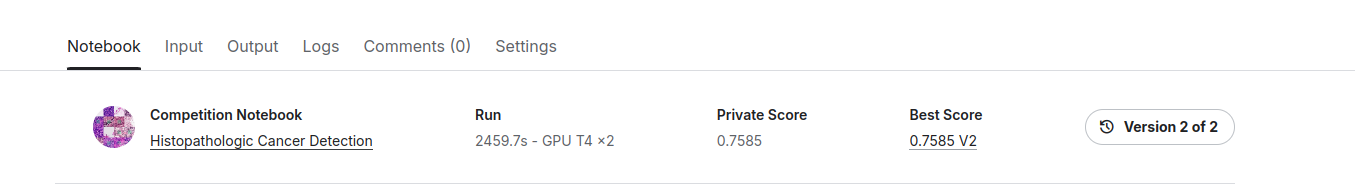

In [3]:
from IPython.display import Image
Image(filename='kaggle_score.png') 


## Final Thoughts 

In this mini project of using the convolutional neural network (CNN) model for metastatic cancer detection, I got very promising results, with a validation accuracy of approximately 80%. This indicates that my model is effectively learning to distinguish between metastatic and non-metastatic images from the PCam dataset. The architecture that i've used, which contains multiple convolutional blocks and dropout layers, has helped the model capture complex patterns while controlling overfitting.

There is much to be done here, for example 


* Hyperparameter Tuning: I plan to experiment with different learning rates, batch sizes, and optimization algorithms
* Data Augmentation: I plan to incorporate methods such as rotation, scaling, flipping,
* Transfer Learning: I will try to leverage pre-trained models like VGG16 or ResNet50.
* Experimenting with Different Architectures: And finally will try different Architectures.





## References 

Kaggle Competition page https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

### Citation
Will Cukierski. (2018). Histopathologic Cancer Detection. Kaggle. https://kaggle.com/competitions/histopathologic-cancer-detection